In [1]:
import os
import glob
import pandas as pd
import numpy as np
import random

file_path = '/Users/ryan/Documents/GitHub/MGT4187-Project/searching_index/results_supplement'
os.chdir(file_path)
file_ls = glob.glob('results_*')

df = pd.concat(pd.read_csv(file) for file in file_ls)



In [2]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'tconst', 'titleType',
       'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear',
       'runtimeMinutes', 'genres', 'title_std', 'release_date', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'distributor',
       'mpaa_rating', 'genre', 'movie_same_name', 'averageRating', 'numVotes',
       'search_index', 'error_message'],
      dtype='object')

In [21]:
df['release_date'] = pd.to_datetime(df['release_date'])

df[['release_date']].describe()


,release_date
count,2135
mean,2009-06-05 23:06:02.529273856
min,2001-01-12 00:00:00
25%,2005-05-27 00:00:00
50%,2009-03-13 00:00:00
75%,2013-07-28 12:00:00
max,2019-03-15 00:00:00


In [16]:
df_runtime = df[['runtimeMinutes']].dropna()

df_runtime['runtimeMinutes'] = df_runtime['runtimeMinutes'].astype(int)
df_runtime[['runtimeMinutes']].describe()

,runtimeMinutes
count,2086.000000
mean,104.527325
std,20.223190
min,4.000000
25%,93.250000
50%,103.000000
75%,115.000000
max,220.000000


In [17]:
df[['production_budget', 'domestic_gross', 'worldwide_gross', 'search_index']].describe()

,production_budget,domestic_gross,worldwide_gross,search_index
count,2.135000e+03,2.135000e+03,2.135000e+03,1542.000000
mean,3.684804e+07,4.521924e+07,9.887153e+07,18.638658
std,3.833615e+07,6.045475e+07,1.499737e+08,20.203926
min,2.500000e+05,0.000000e+00,0.000000e+00,2.076923
25%,1.000000e+07,5.071757e+06,9.618208e+06,6.153846
50%,2.200000e+07,2.418578e+07,4.219577e+07,9.653846
75%,5.000000e+07,5.986743e+07,1.193992e+08,21.216346
max,1.750000e+08,4.412262e+08,1.304866e+09,100.000000


cluster data

In [2]:
cluster_data_path = '/Users/ryan/Documents/GitHub/MGT4187-Project/results_folder/clustering'
os.chdir(cluster_data_path)
cluster = pd.read_excel('movie_with clusters.xlsx')

cluster.sample(5)

,movie,runtimeMinutes,mpaa_rating,movie_popularity,cluster
396,Planet 51,91,PG,0.271674,0
1368,Bucky Larson: Born to Be a Star,97,R,0.161996,0
1499,Dawn of the Planet of the Apes,130,PG-13,0.391442,2
2021,Little Miss Sunshine,101,R,0.370142,1
930,The Life Aquatic with Steve Zissou,119,R,0.345291,1


In [3]:
df = pd.merge(df, cluster[['movie', 'cluster']], on='movie', how='left')

print(df['cluster'].isnull().sum())

df = df.dropna(subset=['cluster'])

41


In [4]:
cluster_dummy = pd.get_dummies(df['cluster'].astype(str), drop_first=True, dtype=float)
cluster_dummy.columns = ['cluster_0', 'cluster_1']
df = pd.concat([df, cluster_dummy], axis=1)

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['profit'] = df['worldwide_gross'] - df['production_budget']

# taking the log
min_profit = df['profit'].min()
offset = abs(min_profit) + 1

df['log_profit'] = np.log(df['profit'] + offset)

df['log_production_budget'] = np.log(df['production_budget']+1)

df['log_numVotes'] = np.log(df['numVotes']+1)
# drop null value
df = df.dropna(subset='search_index')
df = df.reset_index()
# same period movie metrics
def calculate_same_period_metrics_with_id(index, window=5):
    current_release_date = df.iloc[index]['release_date']
    start_date = current_release_date - pd.DateOffset(days=window)
    end_date = current_release_date + pd.DateOffset(days=window)
    same_period = df[(df['release_date'] >= start_date) & (df['release_date'] <= end_date) & (df.index != index)]
    
    if same_period.empty:
        return pd.Series([0, 0, 0, 0, '', 0], index=['same_period_indicator', 'same_period_profit', 'same_period_rating', 'same_period_budget', 'same_period_movie_id', 'same_period_search_index'])
    
    ## make some modification here (average first then log transformation)
    profit_avg = same_period['profit'].mean()
    log_profit = np.log(offset+profit_avg)
    avg_rating = same_period['averageRating'].mean()
    budget_avg = same_period['production_budget'].mean()
    log_budget = np.log(budget_avg+1)
    same_period_movie_id = ','.join(same_period['tconst'])
    avg_search_index = same_period['search_index'].mean()
    
    return pd.Series([1, log_profit, avg_rating, log_budget, same_period_movie_id, avg_search_index], index=['same_period_indicator', 'same_period_profit', 'same_period_rating', 'same_period_budget', 'same_period_movie_id', 'same_period_search_index'])

# Apply the updated function to each movie
df[['same_period_indicator', 'same_period_profit', 'same_period_rating', 'same_period_budget', 'same_period_movie_id', 'same_period_search_index']] = df.index.to_series().apply(calculate_same_period_metrics_with_id)


sentiment analysis

In [5]:
def get_num_topics(x):
    ls = x.split(',')
    num = len(ls) + random.randint(1,5)
    return num
df['num_topics'] = df['genre'].apply(get_num_topics)


In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Regression Model
model_formula = 'log_profit ~ log_production_budget+same_period_profit+same_period_rating+same_period_budget\
                +same_period_budget*same_period_profit\
                        +same_period_budget*same_period_search_index\
                            +same_period_budget*same_period_rating+\
                                same_period_profit*same_period_search_index+\
                                    same_period_profit*same_period_rating+\
                                        same_period_search_index*same_period_rating+\
                                            cluster_0+ cluster_1+\
                                                num_topics+averageRating'

results = ols(model_formula, data=df).fit()

# Conduct ANOVA analysis
anova_results = sm.stats.anova_lm(results, typ=2)

In [7]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_profit   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     30.84
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.08e-76
Time:                        01:19:15   Log-Likelihood:                -553.03
No. Observations:                1483   AIC:                             1138.
Df Residuals:                    1467   BIC:                             1223.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      16.4604      0.140    117.796      0.000      16.186      16.734
log_production_budget                           0.1295      0.007     18.180      0.000       0.116       0.143
same_period_profit                              0.0546      0.089      0.610      0.542      -0.121       0.230
same_period_rating                              0.4914      0.769      0.639      0.523      -1.016       1.999
same_period_budget                             -0.3306      0.304     -1.086      0.278      -0.928       0.266
same_period_budget:same_period_profit           0.0140      0.015      0.939      0.348      -0.015       0.043
same_period_search_index                        0.0494      0.042      1.180      0.238      -0.033       0.132
same_period_budget:same_period_search_index     0.0008      0.001      1.076      0.282      -0.001       0.002
same_period_budget:same_period_rating           0.0111      0.016      0.690      0.490      -0.020       0.043
same_period_profit:same_period_search_index    -0.0034      0.002     -1.389      0.165      -0.008       0.001
same_period_profit:same_period_rating          -0.0355      0.043     -0.818      0.413      -0.120       0.050
same_period_search_index:same_period_rating     0.0001      0.001      0.129      0.897      -0.002       0.002
cluster_0                                      -0.1224      0.022     -5.516      0.000      -0.166      -0.079
cluster_1                                      -0.0984      0.025     -3.970      0.000      -0.147      -0.050
num_topics                                      0.0019      0.007      0.284      0.777      -0.011       0.015
averageRating                                   0.0911      0.010      9.366      0.000       0.072       0.110
==============================================================================
Omnibus:                      212.948   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              469.512
Skew:                           0.829   Prob(JB):                    1.11e-102
Kurtosis:                       5.202   Cond. No.                     5.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

multicollinearity check

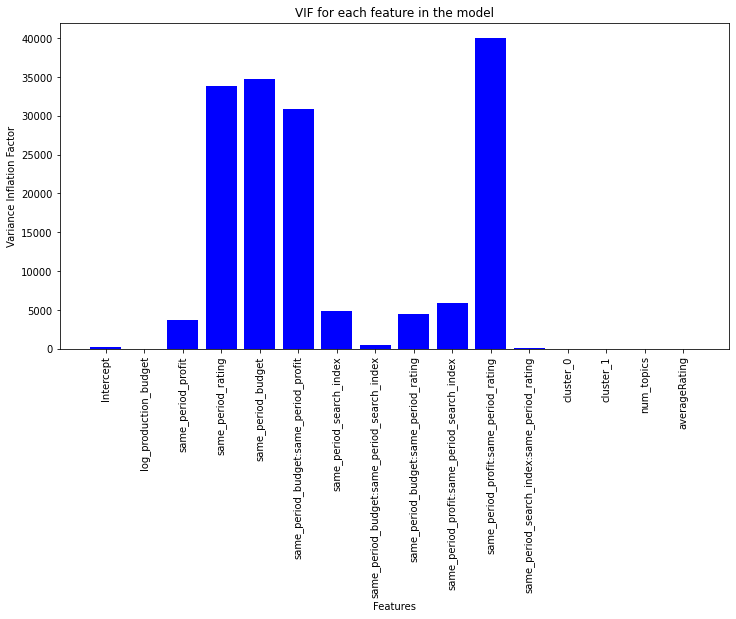

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# Get the predictors from the model
predictors = results.model.exog
features = results.model.exog_names

# Calculate VIFs
vif_data = pd.DataFrame()
vif_data['feature'] = features
vif_data['VIF'] = [variance_inflation_factor(predictors, i) for i in range(len(features))]

# Plotting VIFs for visualization
plt.figure(figsize=(12, 6))
plt.bar(vif_data['feature'], vif_data['VIF'], color='blue')
plt.xlabel('Features')
plt.ylabel('Variance Inflation Factor')
plt.title('VIF for each feature in the model')
plt.xticks(rotation=90)
plt.show()